In [1]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

import numpy as np
import pandas as pd
import glob
from scipy import signal

In [2]:
def half_fft(y, t = None, dt = None):
    """
    Compute the one-sided FFT of a signal.

    Parameters:
        y (numpy.ndarray): The input signal in time domain.
        t (numpy.ndarray, optional): The time array corresponding to the signal. If not provided, `dt` must be specified.
        dt (float, optional): The time step (1/sample rate). If not provided, it will be calculated from `t`.

    Returns:
        tuple: A tuple containing:
            - y_fft (numpy.ndarray): The one-sided FFT of the input signal.
            - freq (numpy.ndarray): The corresponding frequency array.

    Notes:
        - If both `t` and `dt` are not provided, the function will return `None` and print an error message.
        - The FFT is normalized using the 'forward' norm, and the amplitudes are doubled for non-DC components.
    """
    
    if dt is None:
        try:
            dt = np.mean(np.diff(t))
        except:
            print('You must either provide an array of times or a dt (1/sample rate).')
            return None
    
    y_fft = np.fft.fft(y, norm = 'forward')
    freq = np.fft.fftfreq(len(y_fft), dt)

    fidx = freq>=0
    freq=freq[fidx]
    y_fft = y_fft[fidx]
#     y_fft = np.abs(y_fft)
    y_fft[1:]*=2
    
    return y_fft, freq

In [3]:
def makeFFT(freq, pilifer, body, nectary, ax):
    ax[0].plot(freq[1:], np.abs(nectary_fft[1:]), 'k-', label = 'nectary')
    ax[0].legend()
    ax[1].plot(freq[1:], np.abs(body_fft[1:]), 'b-', label = 'body')
    ax[1].legend()
    ax[2].plot(freq[1:], np.abs(pilifer_fft[1:]), 'r-', label = 'pilifer')
    ax[2].legend()
    
    plt.xlim([0,20])
    plt.ylabel('FFT amplitude')
    plt.xlabel('Frequency (Hz)')

In [4]:
filepath= './dataFolder/TrackingData_2022_11_10/thresholded_bodyparts/MV_fixed/'
trackPoints_files = glob.glob(filepath + '*bodyparts.csv')

filepath_another = './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed/'
pilifer_signal_files = glob.glob(filepath_another + '*errorAngle.csv')

In [5]:
pilifer_signal_files

['./dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m11_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m13_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m14_130806_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m1_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m4_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m5_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m8_130805_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m9_130801_errorAngle.csv']

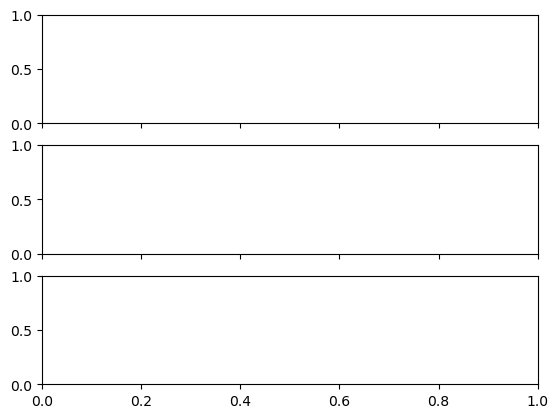

In [24]:
framerate = 100
dt = 1/framerate

fig1, ax = plt.subplots(3,1, sharex= True)
ax = ax.ravel()

fig_directory_RawFFT = './dataFolder/TrackingData_2022_11_10/ErrorAngle/Plots/RawFFT/'

for f in pilifer_signal_files:
    pilifer_signal = pd.read_csv(f, index_col=0)
    mothID = f.split('\\')[-1][:-15]
    
    trackPoints = pd.read_csv([file for file in trackPoints_files if mothID in file][0], index_col=0)
    
    pilifer_signal_smooth = signal.savgol_filter(pilifer_signal.values.flatten(), 5, 3)
    pilifer_signal_smooth_deg = pilifer_signal_smooth*(180/np.pi)
    
    body_lateral = trackPoints.loc[:,'body_x']
    body_smooth = signal.savgol_filter(body_lateral, 5, 3)
    nectary_lateral = trackPoints.loc[:,'nectary_x']
    nectary_smooth = signal.savgol_filter(nectary_lateral, 5, 3)
  
    pilifer_fft, freq = half_fft(pilifer_signal_smooth_deg, dt = dt)
    body_fft, freq = half_fft(body_smooth, dt = dt)
    nectary_fft, freq = half_fft(nectary_smooth, dt = dt)
    
    # find the peaks in the fft of nectary to analyze the rest of it
    peak_locations = signal.find_peaks(np.abs(nectary_fft), prominence = 0.8)[0]
    peak_freqs = freq[peak_locations]
    nectary_fft_value_freq = np.abs(nectary_fft)[peak_locations]
    body_fft_value_freq = np.abs(body_fft)[peak_locations]
    pilifer_fft_value_freq = np.abs(pilifer_fft)[peak_locations]
    
    values_at_peak = pd.DataFrame({'freqs': peak_freqs
                                   ,'nectary': nectary_fft_value_freq
                                  , 'body': body_fft_value_freq
                                  , 'pilifer': pilifer_fft_value_freq})
    values_at_peak.to_csv('./dataFolder/TrackingData_2022_11_10/ErrorAngle/FFT/' + mothID + 'values_at_peak.csv')
    
#     makeFFT(freq, pilifer=pilifer_fft, body=body_fft, nectary=nectary_fft, ax=ax)
#     fig1.savefig(fig_directory_RawFFT + mothID + '_rawFFT.png')
#     for axes in ax:
#         axes.clear()

In [22]:
peak_freqs, nectary_fft_value_freq, body_fft_value_freq, pilifer_fft_value_freq

(array([ 0.4,  0.6,  1. ,  1.4,  2.2,  2.6,  3.4,  3.8,  4.6,  5.8,  7.4,
         8.6, 10.6, 12.2, 15.8, 17.8, 22.6]),
 array([42.12163504, 28.00731713, 17.26240315, 11.33364131,  7.72450668,
         6.48521669,  4.77811472,  4.39837884,  3.6632262 ,  2.82482893,
         2.49535005,  2.30690951,  1.80391033,  1.69885455,  1.56825236,
         1.62190037,  1.45329772]),
 array([43.03298906, 29.93589623, 18.26061682, 12.84482462,  9.45537327,
         7.53672886,  5.76479769,  6.01867301,  5.22080368,  1.16185703,
         0.50384245,  1.08678992,  0.78769694,  0.83909387,  0.61433275,
         0.33360849,  0.22010015]),
 array([1.03658346, 0.61862212, 0.46132128, 0.23703594, 0.39982709,
        0.3766444 , 0.37936679, 0.44796564, 0.48536998, 0.3532675 ,
        0.1556793 , 0.23330839, 0.02105594, 0.11348411, 0.11244   ,
        0.24468842, 0.32415363]))

In [ ]:
# dt = 0.025
# t = np.arange(0, 20, dt)

# u = 2 + 6*np.cos(2*np.pi*t+0.2) + 10*np.sin(10*np.pi*t + 1.5)
# y = 2 + 5*np.cos(2*np.pi*t) + 7*np.sin(10*np.pi*t + 0.5)+3*np.random.randn(len(t))

# plt.plot(t,u)
# plt.plot(t, y)
# plt.show()

In [ ]:
y_fft = np.fft.fft(nectary_lateral, norm = 'forward')
freq = np.fft.fftfreq(len(y_fft), dt)

fidx = freq>=0
freq=freq[fidx]
y_fft = y_fft[fidx]

y_fft[1:]*=2

plt.plot(freq, np.abs(y_fft))
plt.xlim(0.1,15)
plt.ylim(0, 50)

thresh = 1.5
freqs = signal.find_peaks(y_fft, threshold = 0.1)[0]
# np.where(np.abs(y_fft)>=thresh)
plt.plot(freq[freqs], np.abs(y_fft[freqs]), 'or')



plt.show()

In [ ]:
fig, ax = plotBode(u = nectary_lateral, y = body_lateral, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.1
                   , marker = '.', linestyle = '--')
ax[0].set_ylim([0.1, 20])
plt.show()

In [ ]:
fig, ax = plotBode(u = nectary_lateral, y = pilifer_signal, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.01
                   , marker = '.', linestyle = '--')
# ax[0].set_ylim([0.1, 1.1])
plt.show()

In [ ]:
fig, ax = plotBode(u = pilifer_signal, y = body_lateral, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.01
                   , marker = '.', linestyle = '--')
# ax[0].set_ylim([0.1, 1.1])
plt.show()

In [ ]:
freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7]

In [ ]:
freq_idx = [np.where(np.round(freq, decimals=1) == f) for f in freqs]
freq_idx

In [ ]:
for f in freqs:
    print(f)
    print(np.where(np.round(freq, decimals=1) == f))